In [24]:
import os
import shutil

def organize_braTS_data(src_root="./data", dst_root="./dataset"):
    """
    Extract ./TumorSegmentationData to data and label form
    """
    os.makedirs(os.path.join(dst_root, "data"), exist_ok=True)
    os.makedirs(os.path.join(dst_root, "label"), exist_ok=True)
    
    for folder in sorted(os.listdir(src_root)):
        folder_path = os.path.join(src_root, folder)
        if os.path.isdir(folder_path):
            case_number = folder.split("_")[-1]  # Extracting case number
            
            for file in os.listdir(folder_path):
                src_file = os.path.join(folder_path, file)
                if file.endswith("_t1.nii"):
                    dst_file = os.path.join(dst_root, "data", f"data_{case_number}_t1.nii")
                    shutil.move(src_file, dst_file)
                elif file.endswith("_seg.nii"):
                    dst_file = os.path.join(dst_root, "label", f"label_{case_number}.nii")
                    shutil.move(src_file, dst_file)

if __name__ == "__main__":
    organize_braTS_data()

In [25]:
import os
import nibabel as nib
import numpy as np
from scipy import ndimage
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

In [26]:
DEVICE = None
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA!")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU!")
EPOCHS = 100
TRAIN_SPLIT = 0.8
LR = 2e-3
STEP_SIZE = 3
GAMMA = 0.1
MANUAL_SEED = 42
BATCH_SIZE = 16
TARGET_SIZE = 32

Using CUDA!


In [27]:
import torch
import numpy as np
import random

def set_random_seed(seed):
    """
    모든 관련 라이브러리의 랜덤 시드를 고정합니다.
    
    Args:
        seed (int): 고정할 랜덤 시드 값
    """
    # Python 내장 랜덤 시드 고정
    random.seed(seed)
    
    # NumPy 랜덤 시드 고정
    np.random.seed(seed)
    
    # PyTorch 랜덤 시드 고정
    torch.manual_seed(seed)  # CPU에서 PyTorch 랜덤 시드 고정
    torch.cuda.manual_seed(seed)  # GPU에서 PyTorch 랜덤 시드 고정 (CUDA 장치)
    torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 PyTorch 랜덤 시드 고정
    
    # CuDNN 관련 설정
    torch.backends.cudnn.deterministic = True  # 결정적 알고리즘을 사용하여 결과 고정
    torch.backends.cudnn.benchmark = False  # 벤치마크 모드를 비활성화하여 성능 최적화 방지

# 시드 고정 예시
set_random_seed(MANUAL_SEED)

In [28]:
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min_val = -1000
    max_val = 400
    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val
    volume = (volume - min_val) / (max_val - min_val)
    volume = volume.astype("float32")
    return volume


def resize(image, target_size):
    """이미지 크기 조정 (PIL 없이 numpy 기반)"""
    if image.ndim == 2:
        # 흑백 이미지 (H, W) 크기 조정
        return scipy.ndimage.zoom(image, (target_size[0] / image.shape[0], target_size[1] / image.shape[1]), order=1)
    elif image.ndim == 3:
        # 컬러 이미지 (H, W, C) 크기 조정
        zoom_factors = (target_size[0] / image.shape[0], target_size[1] / image.shape[1])
        resized = np.stack([scipy.ndimage.zoom(image[..., i], zoom_factors, order=1) for i in range(image.shape[2])], axis=-1)
        return resized
    else:
        raise ValueError("Unsupported image dimensions")

            
def resize_volume(img):
    """Resize to 64x64x64"""
    desired_depth = TARGET_SIZE
    desired_width = TARGET_SIZE
    desired_height = TARGET_SIZE
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth_factor = desired_depth / current_depth
    width_factor = desired_width / current_width
    height_factor = desired_height / current_height
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

In [29]:
import os

# 경로 설정 (현재 작업 디렉토리 기준)
data_dir = './dataset/label'

# 숫자 001부터 369까지 파일이 있는지 확인 (_001, _002, ...)
expected_files = [f"label_{str(i)}.nii" for i in range(1, 25)]
print(expected_files)
# 실제 파일 목록 가져오기
try:
    actual_files = sorted(os.listdir(data_dir))
    # 실제 파일 목록에 있는지 확인
    missing_files = [file for file in expected_files if file not in actual_files]

    if missing_files:
        print("Missing files:", missing_files)
    else:
        print("All expected files are present.")
except FileNotFoundError:
    print(f"The directory {data_dir} does not exist.")


['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']
Missing files: ['label_1.nii', 'label_2.nii', 'label_3.nii', 'label_4.nii', 'label_5.nii', 'label_6.nii', 'label_7.nii', 'label_8.nii', 'label_9.nii', 'label_10.nii', 'label_11.nii', 'label_12.nii', 'label_13.nii', 'label_14.nii', 'label_15.nii', 'label_16.nii', 'label_17.nii', 'label_18.nii', 'label_19.nii', 'label_20.nii', 'label_21.nii', 'label_22.nii', 'label_23.nii', 'label_24.nii']


In [30]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class BraTSDataset(Dataset):
    def __init__(self, data_dir, label_dir):
        self.data_paths = sorted([f for f in os.listdir(data_dir) if f.endswith('.nii')])
        self.label_paths = sorted([f for f in os.listdir(label_dir) if f.endswith('.nii')])
        self.data_dir = data_dir
        self.label_dir = label_dir

        # 데이터와 라벨의 개수가 일치하는지 확인
        assert len(self.data_paths) == len(self.label_paths), \
            f"Mismatch between data and label files: {len(self.data_paths)} | {len(self.label_paths)}"
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        data_path = os.path.join(self.data_dir, self.data_paths[idx])
        label_path = os.path.join(self.label_dir, self.label_paths[idx])
        
        data = read_nifti_file(data_path)
        label = read_nifti_file(label_path)     

        # 최소, 최대 값 계산
        # min_val = np.min(data)
        # max_val = np.max(data)
        # print(min_val, max_val)
        data = normalize(data)
        data = resize_volume(data)
        label = resize_volume(label)

        # Convert numpy to torch tensor
        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)     # Add channel dimension
        label = torch.tensor(label, dtype=torch.long)                   # For segmentation tasks, long type is needed for one-hot encoding
    
        # One-hot encoding: (64, 64, 64) -> (64, 64, 64, 5) -> (5, 64, 64, 64)
        # label_one_hot = F.one_hot(label, num_classes=5).permute(3, 0, 1, 2).float()
        label_one_hot = label
        return data, label_one_hot


In [31]:
dataset = BraTSDataset("./dataset/data", "./dataset/label")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

data shape:  torch.Size([1, 32, 32, 32]) <class 'torch.Tensor'>
label shape:  torch.Size([32, 32, 32]) <class 'torch.Tensor'>
(32, 32, 32)
torch.Size([32, 32, 32])


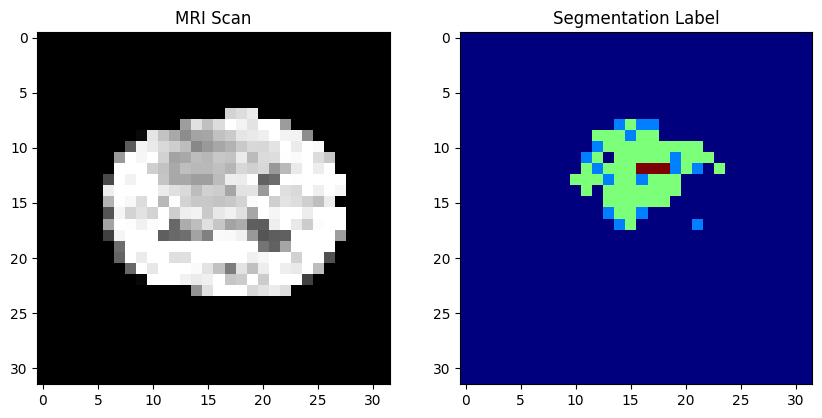

In [32]:
def visualize_sample(dataset, idx=0):
    """Visualize a single sample from the dataset"""
    data, label = dataset[idx]
    print("data shape: ", data.shape, type(data))
    print("label shape: ", label.shape, type(label))
    
    data = data.squeeze().numpy()
    # label = torch.argmax(label, dim=0)
    
    print(data.shape)
    print(label.shape)
    slice_idx = data.shape[-1] // 2  # Select middle slice
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data[:, :, slice_idx], cmap='gray')
    axes[0].set_title("MRI Scan")
    
    axes[1].imshow(label[:, :, slice_idx], cmap='jet')
    axes[1].set_title("Segmentation Label")
    
    plt.show()

visualize_sample(dataset, idx=0)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """ (Conv3D -> BN -> ReLU) * 2 """
    def __init__(self, in_channels, mid_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    """ (Conv3D -> ReLU) * 2 """
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.upconv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels=32):
        super(UNet3D, self).__init__()

        self.encoder1 = DoubleConv(in_channels, base_channels, base_channels * 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder2 = DoubleConv(base_channels * 2, base_channels * 2, base_channels * 4)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder3 = DoubleConv(base_channels * 4, base_channels * 4, base_channels * 8)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder4 = DoubleConv(base_channels * 8, base_channels * 8, base_channels * 16)

        self.upconv3 = UpConv(base_channels * 16, base_channels * 16)
        self.decoder3 = DoubleConv(base_channels * 24, base_channels * 8, base_channels * 8)

        self.upconv2 = UpConv(base_channels * 8, base_channels * 8)
        self.decoder2 = DoubleConv(base_channels * 12, base_channels * 4, base_channels * 4)

        self.upconv1 = UpConv(base_channels * 4, base_channels * 4)
        self.decoder1 = DoubleConv(base_channels * 6, base_channels * 2, base_channels * 2)

        self.outconv = nn.Conv3d(base_channels * 2, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        dec3 = self.upconv3(enc4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.outconv(dec1)

        return out

In [34]:
model = UNet3D(in_channels=1, out_channels=5) # Tumor 1,2,3,4 | 배경
x = torch.randn(1, 1, 64, 64, 64)  # Example 3D volume
output = model(x)
print(output.shape)

torch.Size([1, 5, 64, 64, 64])


In [35]:
import torch
torch.cuda.empty_cache()

In [36]:
from collections import Counter
import numpy as np

# 데이터셋에서 클래스별 샘플 개수 계산
labels = []  # 전체 데이터셋에서 라벨을 수집해야 함

for _, label in train_loader:
    # label = torch.argmax(label, dim=1)  # 원-핫 벡터를 클래스 인덱스로 변환
    labels.extend(label.cpu().numpy().flatten())  # numpy 배열로 변환 후 리스트에 추가

# 클래스별 샘플 개수 계산
class_counts = Counter(labels)
total_samples = sum(class_counts.values())

# 가중치 계산: 총 샘플 수 / (클래스별 샘플 수 * 클래스 개수)
class_weights = {cls: total_samples / (count * len(class_counts)) for cls, count in class_counts.items()}
class_weights = torch.tensor(list(class_weights.values()), dtype=torch.float).to(DEVICE)

print("Class Weights:", class_weights)

Class Weights: tensor([2.0202e-01, 5.1284e+01, 4.6823e+01, 2.7771e+02, 1.7859e+02],
       device='cuda:0')


In [37]:
import os

#현재 폴더 경로; 작업 폴더 기준
print(os.getcwd())

/home/jjpark/SKKAI/3D-Tumor-Segmentation


/home/jjpark/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training with: Learning Rate=0.001, Batch Size=16
Using Dice Loss (ignore_background=True)
Early stopping patience: 15


Epoch 1/100:   0%|          | 0/15 [00:00<?, ?it/s]

Validation 1/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9878, dice=0.0280, loss=0.9720]


Epoch 1/100 - Train Loss: 0.9082, Train Acc: 0.9708, Train Dice: 0.0918, Val Loss: 0.9644, Val Acc: 0.9890, Val Dice: 0.0356, LR: 0.001000
✓ Saved new best model with validation loss: 0.9644 (Dice: 0.0356)


Validation 2/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9857, dice=0.0676, loss=0.9324]


Epoch 2/100 - Train Loss: 0.8979, Train Acc: 0.9722, Train Dice: 0.1021, Val Loss: 0.9208, Val Acc: 0.9856, Val Dice: 0.0792, LR: 0.001000
✓ Saved new best model with validation loss: 0.9208 (Dice: 0.0792)


Validation 3/100: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, acc=0.9878, dice=0.0288, loss=0.9712]


Epoch 3/100 - Train Loss: 0.8934, Train Acc: 0.9742, Train Dice: 0.1066, Val Loss: 0.9628, Val Acc: 0.9890, Val Dice: 0.0372, LR: 0.001000
Early stopping counter: 1/15


Validation 4/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9710, dice=0.0926, loss=0.9074]


Epoch 4/100 - Train Loss: 0.8935, Train Acc: 0.9757, Train Dice: 0.1065, Val Loss: 0.8986, Val Acc: 0.9721, Val Dice: 0.1014, LR: 0.001000
✓ Saved new best model with validation loss: 0.8986 (Dice: 0.1014)


Validation 5/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9258, dice=0.0758, loss=0.9242]


Epoch 5/100 - Train Loss: 0.8947, Train Acc: 0.9761, Train Dice: 0.1053, Val Loss: 0.9190, Val Acc: 0.9227, Val Dice: 0.0810, LR: 0.001000
Early stopping counter: 1/15


Validation 6/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9080, dice=0.0208, loss=0.9792]


Epoch 6/100 - Train Loss: 0.8907, Train Acc: 0.9776, Train Dice: 0.1093, Val Loss: 0.9761, Val Acc: 0.9111, Val Dice: 0.0239, LR: 0.001000
Early stopping counter: 2/15


Validation 7/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9416, dice=0.0667, loss=0.9333]


Epoch 7/100 - Train Loss: 0.8866, Train Acc: 0.9763, Train Dice: 0.1134, Val Loss: 0.9321, Val Acc: 0.9406, Val Dice: 0.0679, LR: 0.001000
Early stopping counter: 3/15


Validation 8/100: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, acc=0.9837, dice=0.0629, loss=0.9371]


Epoch 8/100 - Train Loss: 0.8875, Train Acc: 0.9753, Train Dice: 0.1125, Val Loss: 0.9347, Val Acc: 0.9881, Val Dice: 0.0653, LR: 0.001000
Early stopping counter: 4/15


Validation 9/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9878, dice=0.0278, loss=0.9722]


Epoch 9/100 - Train Loss: 0.8874, Train Acc: 0.9726, Train Dice: 0.1126, Val Loss: 0.9639, Val Acc: 0.9890, Val Dice: 0.0361, LR: 0.001000
Early stopping counter: 5/15


Validation 10/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9597, dice=0.0962, loss=0.9038]


Epoch 10/100 - Train Loss: 0.8871, Train Acc: 0.9799, Train Dice: 0.1129, Val Loss: 0.9009, Val Acc: 0.9595, Val Dice: 0.0991, LR: 0.001000
Early stopping counter: 6/15


Validation 11/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9879, dice=0.0361, loss=0.9639]


Epoch 11/100 - Train Loss: 0.8800, Train Acc: 0.9793, Train Dice: 0.1200, Val Loss: 0.9555, Val Acc: 0.9891, Val Dice: 0.0445, LR: 0.000500
Early stopping counter: 7/15


Validation 12/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9864, dice=0.0561, loss=0.9439]


Epoch 12/100 - Train Loss: 0.8770, Train Acc: 0.9784, Train Dice: 0.1230, Val Loss: 0.9464, Val Acc: 0.9879, Val Dice: 0.0536, LR: 0.000500
Early stopping counter: 8/15


Validation 13/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9877, dice=0.0875, loss=0.9125]


Epoch 13/100 - Train Loss: 0.8759, Train Acc: 0.9782, Train Dice: 0.1241, Val Loss: 0.9113, Val Acc: 0.9882, Val Dice: 0.0887, LR: 0.000500
Early stopping counter: 9/15


Validation 14/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9756, dice=0.1194, loss=0.8806]


Epoch 14/100 - Train Loss: 0.8732, Train Acc: 0.9784, Train Dice: 0.1268, Val Loss: 0.8802, Val Acc: 0.9739, Val Dice: 0.1198, LR: 0.000500
✓ Saved new best model with validation loss: 0.8802 (Dice: 0.1198)


Validation 15/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.4350, dice=0.0338, loss=0.9662]


Epoch 15/100 - Train Loss: 0.8744, Train Acc: 0.9800, Train Dice: 0.1256, Val Loss: 0.9565, Val Acc: 0.4304, Val Dice: 0.0435, LR: 0.000500
Early stopping counter: 1/15


Validation 16/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9785, dice=0.1132, loss=0.8868]


Epoch 16/100 - Train Loss: 0.8754, Train Acc: 0.9796, Train Dice: 0.1246, Val Loss: 0.8803, Val Acc: 0.9765, Val Dice: 0.1197, LR: 0.000500
Early stopping counter: 2/15


Validation 17/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9878, dice=0.0274, loss=0.9726]


Epoch 17/100 - Train Loss: 0.8744, Train Acc: 0.9793, Train Dice: 0.1256, Val Loss: 0.9641, Val Acc: 0.9890, Val Dice: 0.0359, LR: 0.000500
Early stopping counter: 3/15


Validation 18/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9657, dice=0.1230, loss=0.8770]


Epoch 18/100 - Train Loss: 0.8742, Train Acc: 0.9809, Train Dice: 0.1258, Val Loss: 0.8830, Val Acc: 0.9607, Val Dice: 0.1170, LR: 0.000500
Early stopping counter: 4/15


Validation 19/100: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, acc=0.9745, dice=0.1130, loss=0.8870]


Epoch 19/100 - Train Loss: 0.8691, Train Acc: 0.9803, Train Dice: 0.1309, Val Loss: 0.8840, Val Acc: 0.9728, Val Dice: 0.1160, LR: 0.000500
Early stopping counter: 5/15


Validation 20/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9875, dice=0.1032, loss=0.8968]


Epoch 20/100 - Train Loss: 0.8681, Train Acc: 0.9803, Train Dice: 0.1319, Val Loss: 0.8935, Val Acc: 0.9878, Val Dice: 0.1065, LR: 0.000500
Early stopping counter: 6/15


Validation 21/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9771, dice=0.1120, loss=0.8880]


Epoch 21/100 - Train Loss: 0.8646, Train Acc: 0.9816, Train Dice: 0.1354, Val Loss: 0.8747, Val Acc: 0.9780, Val Dice: 0.1253, LR: 0.000250
✓ Saved new best model with validation loss: 0.8747 (Dice: 0.1253)


Validation 22/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9889, dice=0.0903, loss=0.9097]


Epoch 22/100 - Train Loss: 0.8638, Train Acc: 0.9815, Train Dice: 0.1362, Val Loss: 0.9168, Val Acc: 0.9896, Val Dice: 0.0832, LR: 0.000250
Early stopping counter: 1/15


Validation 23/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9860, dice=0.1108, loss=0.8892]


Epoch 23/100 - Train Loss: 0.8605, Train Acc: 0.9822, Train Dice: 0.1395, Val Loss: 0.8790, Val Acc: 0.9864, Val Dice: 0.1210, LR: 0.000250
Early stopping counter: 2/15


Validation 24/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9886, dice=0.0882, loss=0.9118]


Epoch 24/100 - Train Loss: 0.8612, Train Acc: 0.9826, Train Dice: 0.1388, Val Loss: 0.9094, Val Acc: 0.9894, Val Dice: 0.0906, LR: 0.000250
Early stopping counter: 3/15


Validation 25/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9773, dice=0.1135, loss=0.8865]


Epoch 25/100 - Train Loss: 0.8607, Train Acc: 0.9830, Train Dice: 0.1393, Val Loss: 0.8729, Val Acc: 0.9761, Val Dice: 0.1271, LR: 0.000250
✓ Saved new best model with validation loss: 0.8729 (Dice: 0.1271)


Validation 26/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9679, dice=0.0634, loss=0.9366]


Epoch 26/100 - Train Loss: 0.8585, Train Acc: 0.9823, Train Dice: 0.1415, Val Loss: 0.9332, Val Acc: 0.9689, Val Dice: 0.0668, LR: 0.000250
Early stopping counter: 1/15


Validation 27/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9522, dice=0.0602, loss=0.9398]


Epoch 27/100 - Train Loss: 0.8562, Train Acc: 0.9825, Train Dice: 0.1438, Val Loss: 0.9331, Val Acc: 0.9543, Val Dice: 0.0669, LR: 0.000250
Early stopping counter: 2/15


Validation 28/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9809, dice=0.0798, loss=0.9202]


Epoch 28/100 - Train Loss: 0.8556, Train Acc: 0.9827, Train Dice: 0.1444, Val Loss: 0.9097, Val Acc: 0.9830, Val Dice: 0.0903, LR: 0.000250
Early stopping counter: 3/15


Validation 29/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9305, dice=0.0496, loss=0.9504]


Epoch 29/100 - Train Loss: 0.8543, Train Acc: 0.9835, Train Dice: 0.1457, Val Loss: 0.9446, Val Acc: 0.9318, Val Dice: 0.0554, LR: 0.000250
Early stopping counter: 4/15


Validation 30/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9779, dice=0.1268, loss=0.8732]


Epoch 30/100 - Train Loss: 0.8536, Train Acc: 0.9827, Train Dice: 0.1464, Val Loss: 0.8733, Val Acc: 0.9784, Val Dice: 0.1267, LR: 0.000250
Early stopping counter: 5/15


Validation 31/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9700, dice=0.1230, loss=0.8770]


Epoch 31/100 - Train Loss: 0.8553, Train Acc: 0.9834, Train Dice: 0.1447, Val Loss: 0.8731, Val Acc: 0.9689, Val Dice: 0.1269, LR: 0.000250
Early stopping counter: 6/15


Validation 32/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9419, dice=0.0514, loss=0.9486]


Epoch 32/100 - Train Loss: 0.8525, Train Acc: 0.9827, Train Dice: 0.1475, Val Loss: 0.9439, Val Acc: 0.9406, Val Dice: 0.0561, LR: 0.000125
Early stopping counter: 7/15


Validation 33/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9801, dice=0.1127, loss=0.8873]


Epoch 33/100 - Train Loss: 0.8498, Train Acc: 0.9841, Train Dice: 0.1502, Val Loss: 0.8803, Val Acc: 0.9812, Val Dice: 0.1197, LR: 0.000125
Early stopping counter: 8/15


Validation 34/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9865, dice=0.1094, loss=0.8906]


Epoch 34/100 - Train Loss: 0.8517, Train Acc: 0.9833, Train Dice: 0.1483, Val Loss: 0.8743, Val Acc: 0.9870, Val Dice: 0.1257, LR: 0.000125
Early stopping counter: 9/15


Validation 35/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9788, dice=0.1167, loss=0.8833]


Epoch 35/100 - Train Loss: 0.8492, Train Acc: 0.9835, Train Dice: 0.1508, Val Loss: 0.8696, Val Acc: 0.9776, Val Dice: 0.1304, LR: 0.000125
✓ Saved new best model with validation loss: 0.8696 (Dice: 0.1304)


Validation 36/100: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, acc=0.9805, dice=0.1236, loss=0.8764]


Epoch 36/100 - Train Loss: 0.8497, Train Acc: 0.9837, Train Dice: 0.1503, Val Loss: 0.8671, Val Acc: 0.9800, Val Dice: 0.1329, LR: 0.000125
✓ Saved new best model with validation loss: 0.8671 (Dice: 0.1329)


Validation 37/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9511, dice=0.0659, loss=0.9341]


Epoch 37/100 - Train Loss: 0.8471, Train Acc: 0.9845, Train Dice: 0.1529, Val Loss: 0.9284, Val Acc: 0.9520, Val Dice: 0.0716, LR: 0.000125
Early stopping counter: 1/15


Validation 38/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9861, dice=0.1016, loss=0.8984]


Epoch 38/100 - Train Loss: 0.8470, Train Acc: 0.9832, Train Dice: 0.1530, Val Loss: 0.8855, Val Acc: 0.9860, Val Dice: 0.1145, LR: 0.000125
Early stopping counter: 2/15


Validation 39/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9862, dice=0.1124, loss=0.8876]


Epoch 39/100 - Train Loss: 0.8480, Train Acc: 0.9840, Train Dice: 0.1520, Val Loss: 0.8743, Val Acc: 0.9866, Val Dice: 0.1257, LR: 0.000125
Early stopping counter: 3/15


Validation 40/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9863, dice=0.1062, loss=0.8938]


Epoch 40/100 - Train Loss: 0.8453, Train Acc: 0.9839, Train Dice: 0.1547, Val Loss: 0.8704, Val Acc: 0.9862, Val Dice: 0.1296, LR: 0.000125
Early stopping counter: 4/15


Validation 41/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9884, dice=0.0996, loss=0.9004]


Epoch 41/100 - Train Loss: 0.8474, Train Acc: 0.9832, Train Dice: 0.1526, Val Loss: 0.8869, Val Acc: 0.9891, Val Dice: 0.1131, LR: 0.000125
Early stopping counter: 5/15


Validation 42/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9882, dice=0.1126, loss=0.8874]


Epoch 42/100 - Train Loss: 0.8467, Train Acc: 0.9844, Train Dice: 0.1533, Val Loss: 0.8789, Val Acc: 0.9886, Val Dice: 0.1211, LR: 0.000125
Early stopping counter: 6/15


Validation 43/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9834, dice=0.1192, loss=0.8808]


Epoch 43/100 - Train Loss: 0.8439, Train Acc: 0.9846, Train Dice: 0.1561, Val Loss: 0.8673, Val Acc: 0.9829, Val Dice: 0.1327, LR: 0.000063
Early stopping counter: 7/15


Validation 44/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9855, dice=0.1093, loss=0.8907]


Epoch 44/100 - Train Loss: 0.8436, Train Acc: 0.9841, Train Dice: 0.1564, Val Loss: 0.8698, Val Acc: 0.9850, Val Dice: 0.1302, LR: 0.000063
Early stopping counter: 8/15


Validation 45/100: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, acc=0.9831, dice=0.1189, loss=0.8811]


Epoch 45/100 - Train Loss: 0.8437, Train Acc: 0.9832, Train Dice: 0.1563, Val Loss: 0.8666, Val Acc: 0.9822, Val Dice: 0.1334, LR: 0.000063
✓ Saved new best model with validation loss: 0.8666 (Dice: 0.1334)
Early stopping counter: 9/15


Validation 46/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9858, dice=0.1080, loss=0.8920]


Epoch 46/100 - Train Loss: 0.8427, Train Acc: 0.9846, Train Dice: 0.1573, Val Loss: 0.8688, Val Acc: 0.9854, Val Dice: 0.1312, LR: 0.000063
Early stopping counter: 10/15


Validation 47/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9832, dice=0.1161, loss=0.8839]


Epoch 47/100 - Train Loss: 0.8424, Train Acc: 0.9846, Train Dice: 0.1576, Val Loss: 0.8668, Val Acc: 0.9825, Val Dice: 0.1332, LR: 0.000063
Early stopping counter: 11/15


Validation 48/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9847, dice=0.1123, loss=0.8877]


Epoch 48/100 - Train Loss: 0.8429, Train Acc: 0.9851, Train Dice: 0.1571, Val Loss: 0.8680, Val Acc: 0.9837, Val Dice: 0.1320, LR: 0.000063
Early stopping counter: 12/15


Validation 49/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9811, dice=0.1281, loss=0.8719]


Epoch 49/100 - Train Loss: 0.8432, Train Acc: 0.9859, Train Dice: 0.1568, Val Loss: 0.8657, Val Acc: 0.9797, Val Dice: 0.1343, LR: 0.000063
✓ Saved new best model with validation loss: 0.8657 (Dice: 0.1343)


Validation 50/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9826, dice=0.1096, loss=0.8904]


Epoch 50/100 - Train Loss: 0.8424, Train Acc: 0.9840, Train Dice: 0.1576, Val Loss: 0.8794, Val Acc: 0.9821, Val Dice: 0.1206, LR: 0.000063
Early stopping counter: 1/15


Validation 51/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9868, dice=0.1065, loss=0.8935]


Epoch 51/100 - Train Loss: 0.8411, Train Acc: 0.9844, Train Dice: 0.1589, Val Loss: 0.8731, Val Acc: 0.9865, Val Dice: 0.1269, LR: 0.000063
Early stopping counter: 2/15


Validation 52/100: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, acc=0.9844, dice=0.1125, loss=0.8875]


Epoch 52/100 - Train Loss: 0.8415, Train Acc: 0.9841, Train Dice: 0.1585, Val Loss: 0.8678, Val Acc: 0.9836, Val Dice: 0.1322, LR: 0.000063
Early stopping counter: 3/15


Validation 53/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9837, dice=0.1150, loss=0.8850]


Epoch 53/100 - Train Loss: 0.8405, Train Acc: 0.9846, Train Dice: 0.1595, Val Loss: 0.8744, Val Acc: 0.9828, Val Dice: 0.1256, LR: 0.000063
Early stopping counter: 4/15


Validation 54/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9881, dice=0.1022, loss=0.8978]


Epoch 54/100 - Train Loss: 0.8417, Train Acc: 0.9841, Train Dice: 0.1583, Val Loss: 0.8768, Val Acc: 0.9883, Val Dice: 0.1232, LR: 0.000063
Early stopping counter: 5/15


Validation 55/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9867, dice=0.1072, loss=0.8928]


Epoch 55/100 - Train Loss: 0.8405, Train Acc: 0.9845, Train Dice: 0.1595, Val Loss: 0.8701, Val Acc: 0.9865, Val Dice: 0.1299, LR: 0.000063
Early stopping counter: 6/15


Validation 56/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9849, dice=0.1123, loss=0.8877]


Epoch 56/100 - Train Loss: 0.8405, Train Acc: 0.9846, Train Dice: 0.1595, Val Loss: 0.8674, Val Acc: 0.9840, Val Dice: 0.1326, LR: 0.000031
Early stopping counter: 7/15


Validation 57/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9843, dice=0.1140, loss=0.8860]


Epoch 57/100 - Train Loss: 0.8390, Train Acc: 0.9850, Train Dice: 0.1610, Val Loss: 0.8672, Val Acc: 0.9834, Val Dice: 0.1328, LR: 0.000031
Early stopping counter: 8/15


Validation 58/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9859, dice=0.1106, loss=0.8894]


Epoch 58/100 - Train Loss: 0.8389, Train Acc: 0.9847, Train Dice: 0.1611, Val Loss: 0.8688, Val Acc: 0.9852, Val Dice: 0.1312, LR: 0.000031
Early stopping counter: 9/15


Validation 59/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9841, dice=0.1149, loss=0.8851]


Epoch 59/100 - Train Loss: 0.8387, Train Acc: 0.9852, Train Dice: 0.1613, Val Loss: 0.8687, Val Acc: 0.9834, Val Dice: 0.1313, LR: 0.000031
Early stopping counter: 10/15


Validation 60/100: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, acc=0.9833, dice=0.1174, loss=0.8826]


Epoch 60/100 - Train Loss: 0.8389, Train Acc: 0.9851, Train Dice: 0.1611, Val Loss: 0.8672, Val Acc: 0.9824, Val Dice: 0.1328, LR: 0.000031
Early stopping counter: 11/15


Validation 61/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9843, dice=0.1153, loss=0.8847]


Epoch 61/100 - Train Loss: 0.8390, Train Acc: 0.9851, Train Dice: 0.1610, Val Loss: 0.8671, Val Acc: 0.9836, Val Dice: 0.1329, LR: 0.000031
Early stopping counter: 12/15


Validation 62/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9868, dice=0.1074, loss=0.8926]


Epoch 62/100 - Train Loss: 0.8380, Train Acc: 0.9847, Train Dice: 0.1620, Val Loss: 0.8706, Val Acc: 0.9864, Val Dice: 0.1294, LR: 0.000016
Early stopping counter: 13/15


Validation 63/100: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s, acc=0.9839, dice=0.1159, loss=0.8841]


Epoch 63/100 - Train Loss: 0.8387, Train Acc: 0.9854, Train Dice: 0.1613, Val Loss: 0.8668, Val Acc: 0.9829, Val Dice: 0.1332, LR: 0.000016
Early stopping counter: 14/15


Validation 64/100: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, acc=0.9852, dice=0.1123, loss=0.8877]


Epoch 64/100 - Train Loss: 0.8386, Train Acc: 0.9847, Train Dice: 0.1614, Val Loss: 0.8675, Val Acc: 0.9842, Val Dice: 0.1325, LR: 0.000016
Early stopping counter: 15/15
Early stopping triggered
Early stopping triggered after 64 epochs

Training completed! Best validation loss: 0.8657


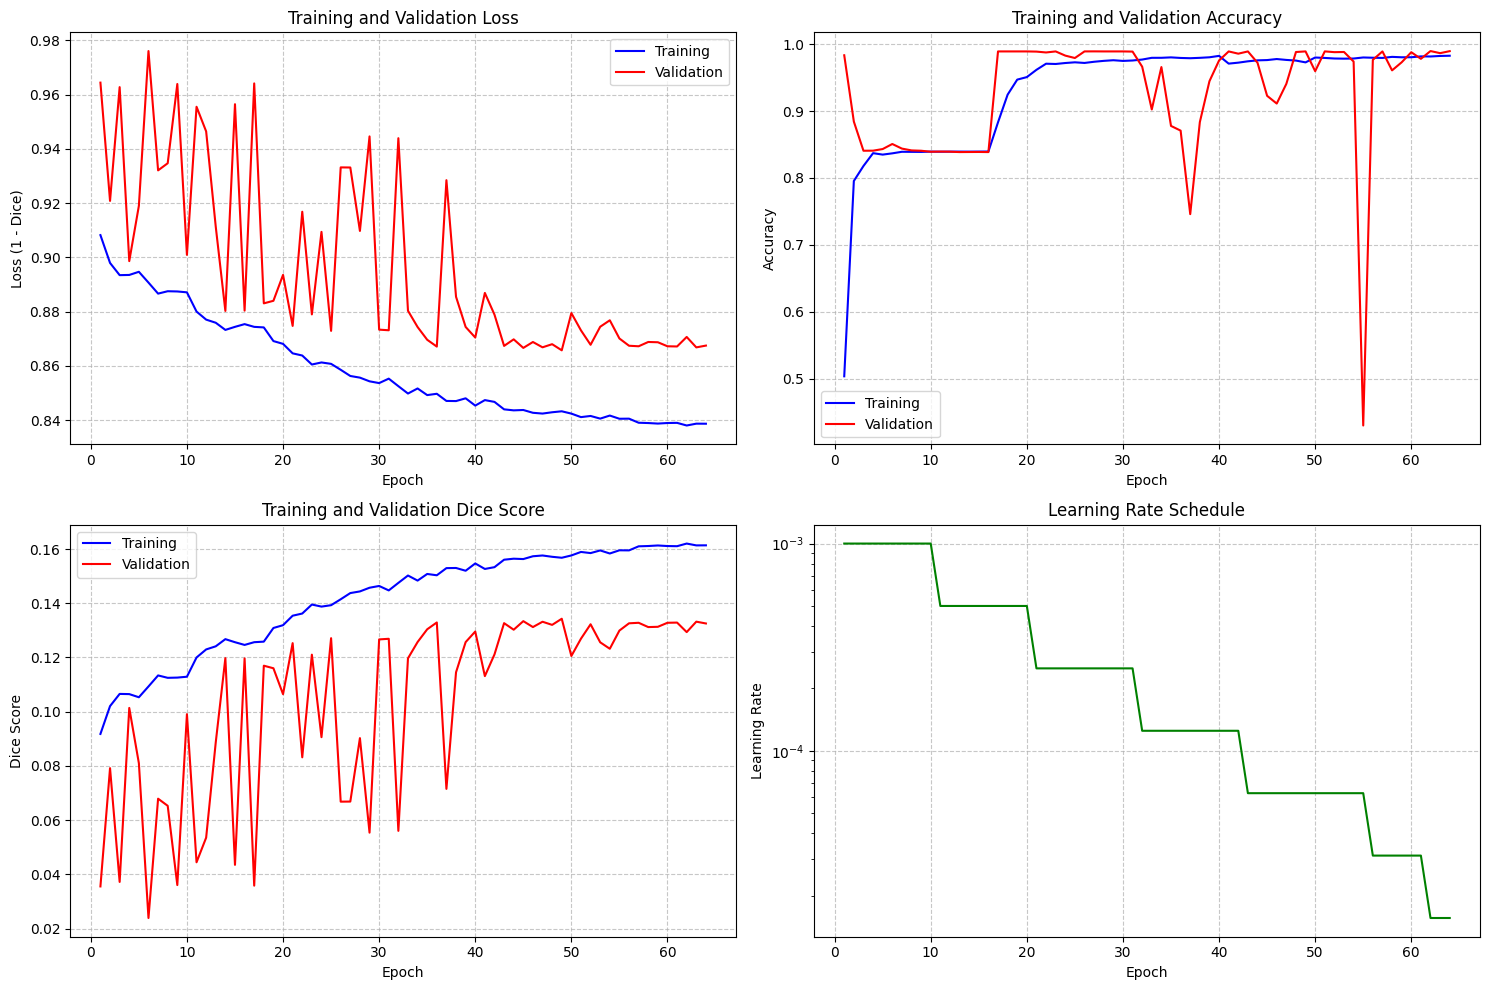

Best model at epoch 49 with validation Dice score: 0.1343
Loading best model for visualization...
Loaded model from epoch 49 with Dice score: 0.1343


/tmp/ipykernel_2452238/718194248.py:498: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./model/3DUNet_best.pth')


Visualizing sample 1


/tmp/ipykernel_2452238/718194248.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


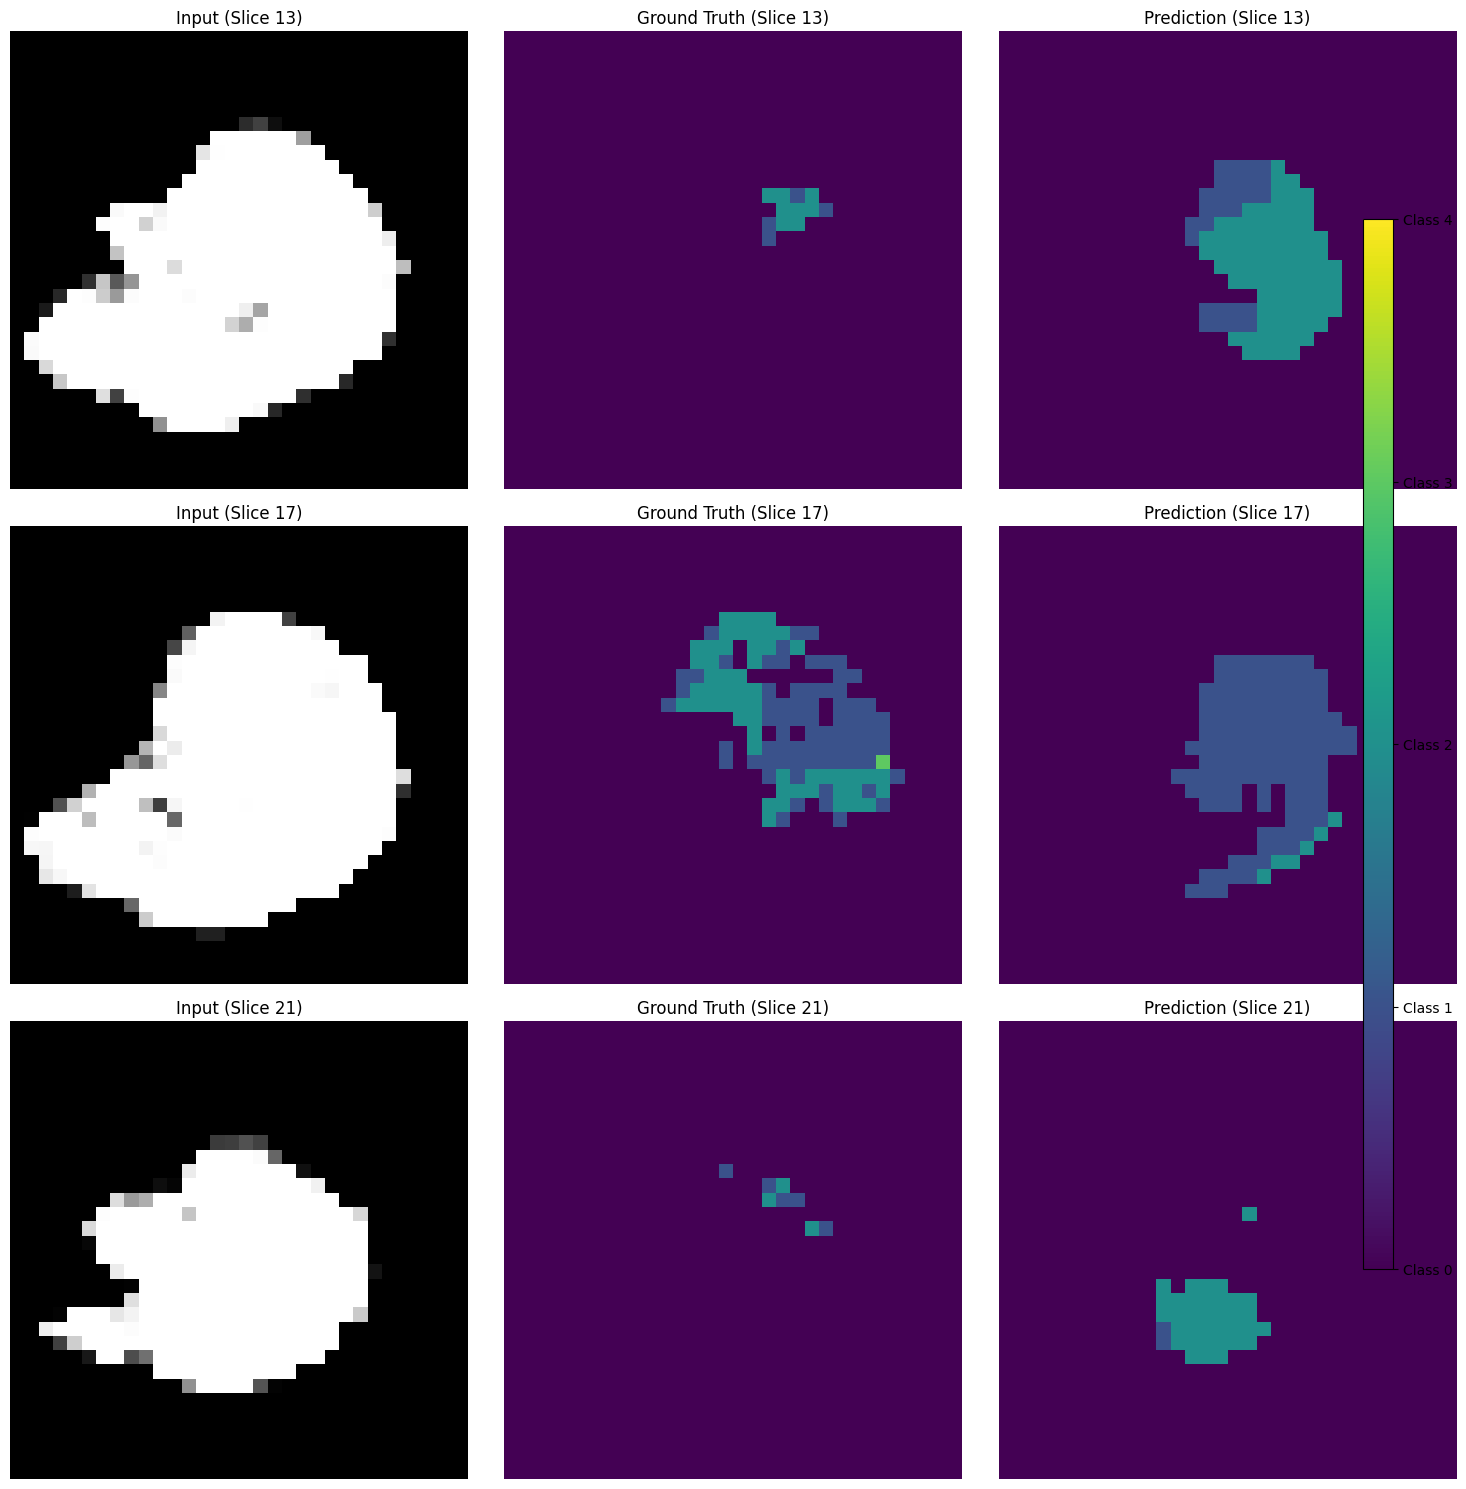

Visualizing sample 2


/tmp/ipykernel_2452238/718194248.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


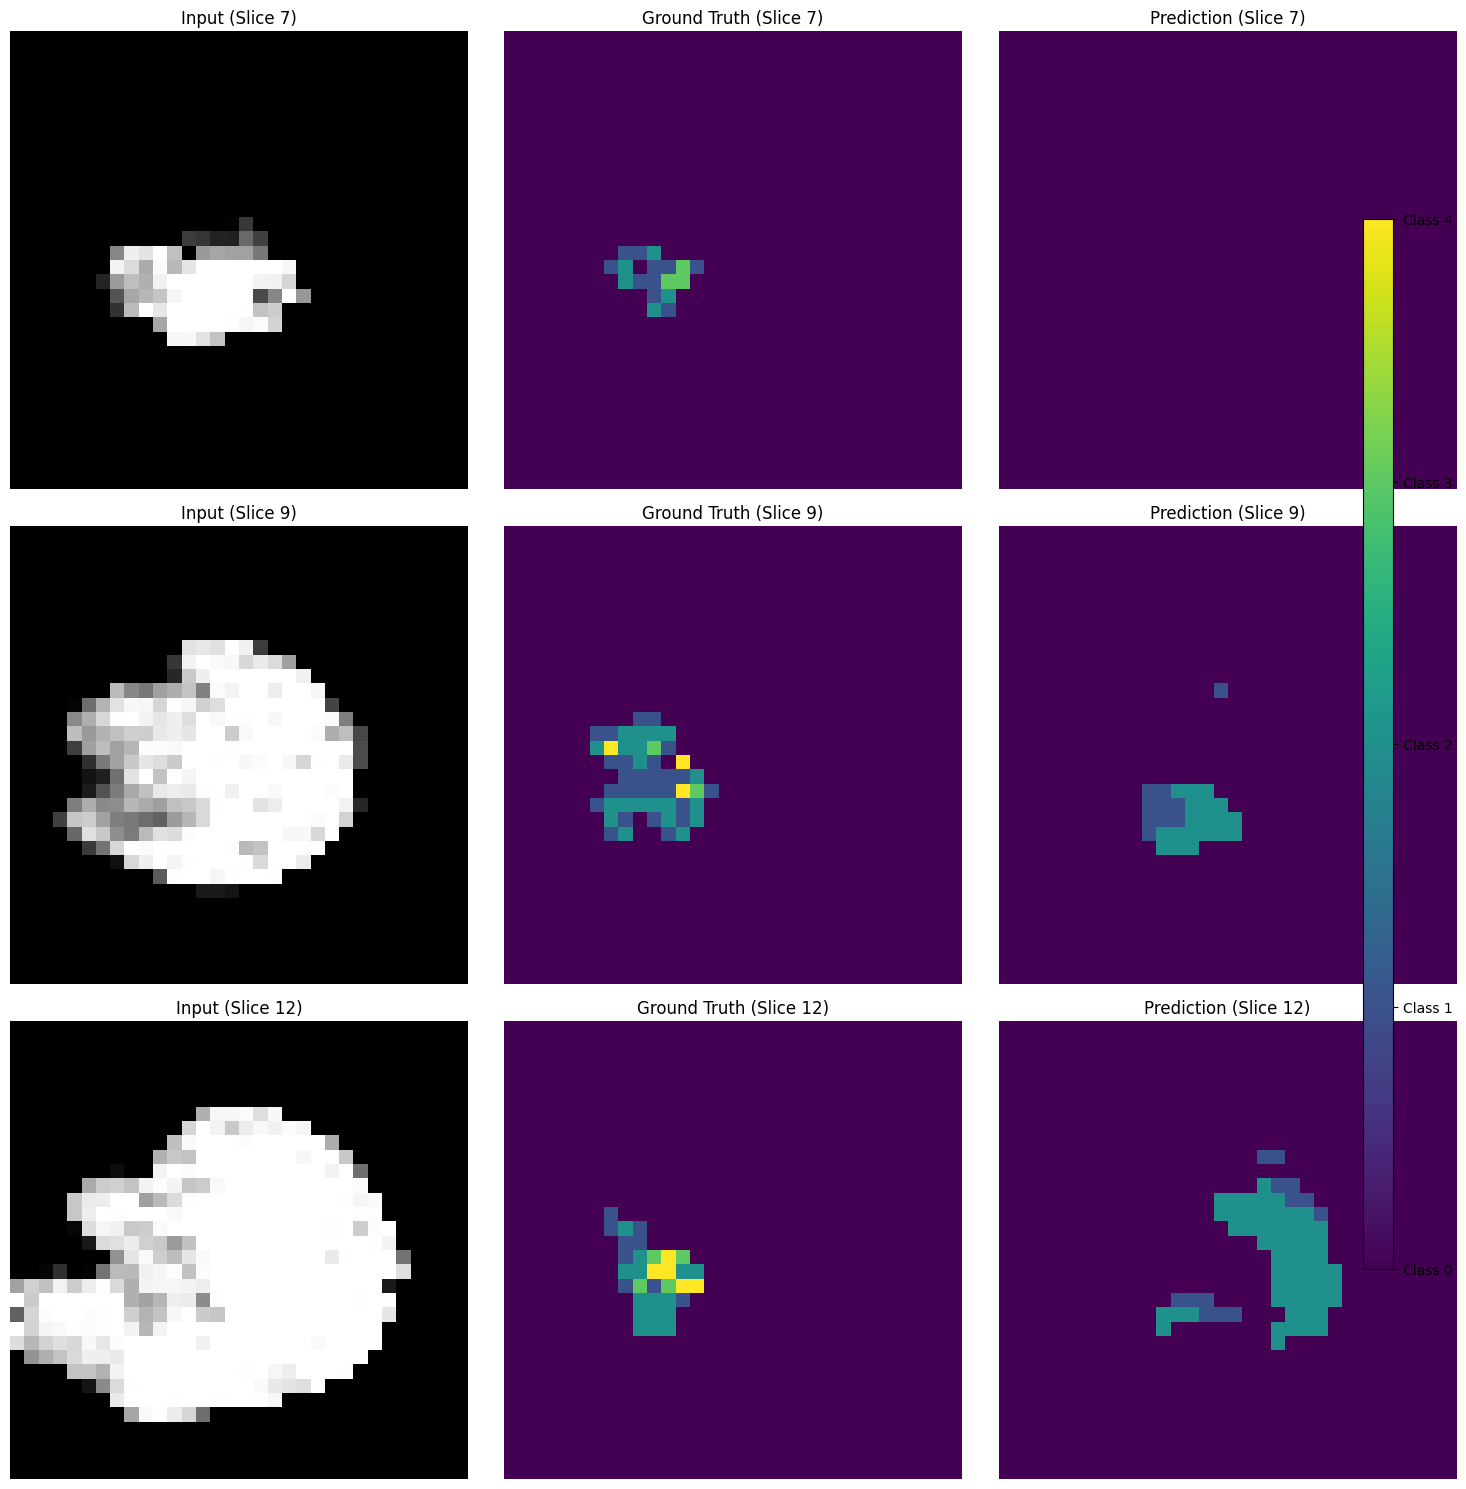

In [45]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader

# Create directories if they don't exist
os.makedirs('./model', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# ========== 1. DICE LOSS IMPLEMENTATION ==========
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, ignore_background=True):
        """
        Dice Loss for segmentation tasks
        
        Args:
            smooth (float): Smoothing value to avoid division by zero
            ignore_background (bool): Whether to ignore background class (index 0)
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_background = ignore_background
        
    def forward(self, inputs, targets):
        """
        Calculate Dice Loss
        
        Args:
            inputs: Model predictions (B, C, D, H, W)
            targets: Ground truth labels (B, D, H, W)
            
        Returns:
            Loss value
        """
        # Get softmax probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # Convert targets to one-hot encoding
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        
        # Flatten the spatial dimensions
        inputs = inputs.reshape(inputs.size(0), inputs.size(1), -1)
        targets_one_hot = targets_one_hot.reshape(targets_one_hot.size(0), targets_one_hot.size(1), -1)
        
        # Calculate Dice coefficient for each class and batch
        dice_scores = []
        
        # Loop through classes
        start_idx = 1 if self.ignore_background else 0
        
        for cls in range(start_idx, num_classes):
            # Get current class predictions and targets
            input_cls = inputs[:, cls, :]  # (B, D*H*W)
            target_cls = targets_one_hot[:, cls, :]  # (B, D*H*W)
            
            # Calculate intersection and union
            intersection = (input_cls * target_cls).sum(dim=1)  # (B)
            sum_inputs = input_cls.sum(dim=1)  # (B)
            sum_targets = target_cls.sum(dim=1)  # (B)
            
            # Dice coefficient
            dice = (2.0 * intersection + self.smooth) / (sum_inputs + sum_targets + self.smooth)  # (B)
            
            # Skip empty target slices (for stability)
            non_empty = sum_targets > 0
            if non_empty.sum() > 0:
                dice_valid = dice[non_empty]
                dice_scores.append(dice_valid.mean())
        
        # Check if we have any valid dice scores
        if len(dice_scores) == 0:
            # If no valid scores (e.g., all background), return a loss value
            # that encourages the model to predict background
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        
        # Average Dice score
        dice_avg = torch.stack(dice_scores).mean()
        
        # Return Dice loss (1 - Dice coefficient)
        return 1.0 - dice_avg

# ========== 2. DICE METRIC CALCULATION ==========
def calculate_dice_coefficient(outputs, targets, ignore_background=True):
    """
    Calculate Dice coefficient for evaluation
    
    Args:
        outputs: Model outputs (B, C, D, H, W)
        targets: Ground truth labels (B, D, H, W)
        ignore_background: Whether to ignore background class (index 0)
        
    Returns:
        Dice coefficient
    """
    # Get predicted class
    _, predicted = torch.max(outputs, 1)  # (B, D, H, W)
    
    # Get number of classes
    num_classes = outputs.size(1)
    
    # Calculate Dice for each class
    dice_scores = []
    
    # Loop through classes
    start_idx = 1 if ignore_background else 0
    
    for cls in range(start_idx, num_classes):
        # Create binary masks for this class
        pred_mask = (predicted == cls).float()  # (B, D, H, W)
        true_mask = (targets == cls).float()    # (B, D, H, W)
        
        # Skip if no ground truth for this class
        if true_mask.sum() == 0:
            continue
            
        # Calculate intersection and union
        intersection = (pred_mask * true_mask).sum()
        union = pred_mask.sum() + true_mask.sum()
        
        # Dice coefficient
        dice = (2.0 * intersection + 1.0) / (union + 1.0)
        dice_scores.append(dice.item())
    
    # Return mean Dice coefficient
    if len(dice_scores) > 0:
        return sum(dice_scores) / len(dice_scores)
    else:
        return 1.0  # Perfect dice if no foreground classes (all background)

# ========== 3. EARLY STOPPING ==========
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, verbose=True):
        """
        Early stopping to stop training when validation loss doesn't improve.
        
        Args:
            patience (int): Number of epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints a message when early stopping triggers
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        """
        Check if training should be stopped.
        
        Args:
            val_loss (float): Current validation loss
            
        Returns:
            bool: True if training should stop, False otherwise
        """
        if val_loss < self.best_loss - self.min_delta:
            # Validation loss has improved
            self.best_loss = val_loss
            self.counter = 0
        else:
            # Validation loss has not improved
            self.counter += 1
            if self.verbose:
                print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')
        
        return self.early_stop

# ========== 4. DATASET SETUP ==========
dataset_size = len(train_dataset)
val_size = int(dataset_size * 0.2)  
train_size = dataset_size - val_size

train_subset, val_subset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42) 
)

train_loader = DataLoader(
    train_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS if 'NUM_WORKERS' in globals() else 4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS if 'NUM_WORKERS' in globals() else 4
)

# ========== 5. TRAINING SETUP ==========
model.to(DEVICE)

# Use Dice Loss instead of CrossEntropyLoss
criterion = DiceLoss(smooth=1.0, ignore_background=True)

# Lower learning rate for stability with Dice Loss
LR_DICE = LR * 0.5  # Half the original learning rate for stability

optimizer = optim.Adam(model.parameters(), lr=LR_DICE)

# Use ReduceLROnPlateau instead of StepLR for better adaptation
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

# Initialize tracking variables
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_dices = []
val_dices = []
lr_history = []

# Initialize early stopping
early_stopping = EarlyStopping(patience=15, min_delta=0.001, verbose=True)

# ========== 6. UTILITY FUNCTIONS ==========
def calculate_accuracy(outputs, labels):
    """Calculate pixel-wise accuracy"""
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.numel()
    return correct / total

# ========== 7. TRAINING LOOP ==========
print(f"Starting training with: Learning Rate={LR_DICE}, Batch Size={BATCH_SIZE}")
print(f"Using Dice Loss (ignore_background={criterion.ignore_background})")
print(f"Early stopping patience: {early_stopping.patience}")

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0
    train_dice = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for data, label in progress_bar:
        data, label = data.to(DEVICE), label.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, label)
        
        # Handle NaN loss
        if torch.isnan(loss):
            print(f"Warning: NaN loss encountered. Skipping batch.")
            continue
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Calculate metrics
        acc = calculate_accuracy(output, label)
        dice = 1.0 - loss.item()  # Dice score = 1 - Dice loss
        
        # Update progress bar
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}", dice=f"{dice:.4f}")
        
        # Update running metrics
        train_loss += loss.item()
        train_acc += acc
        train_dice += dice
    
    # Calculate average training metrics
    samples = len(train_loader)
    train_loss = train_loss / samples
    train_acc = train_acc / samples
    train_dice = train_dice / samples
    
    # Store metrics for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_dices.append(train_dice)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    val_dice = 0
    
    with torch.no_grad():
        val_progress_bar = tqdm(val_loader, desc=f"Validation {epoch+1}/{EPOCHS}")
        for data, label in val_progress_bar:
            data, label = data.to(DEVICE), label.to(DEVICE)
            
            # Forward pass
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, label)
            
            # Handle NaN loss
            if torch.isnan(loss):
                print(f"Warning: NaN validation loss. Skipping batch.")
                continue
            
            # Calculate metrics
            acc = calculate_accuracy(output, label)
            dice = 1.0 - loss.item()  # Dice score = 1 - Dice loss
            
            # Update progress bar
            val_progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}", dice=f"{dice:.4f}")
            
            # Update running metrics
            val_loss += loss.item()
            val_acc += acc
            val_dice += dice
    
    # Calculate average validation metrics
    val_samples = len(val_loader)
    val_loss = val_loss / val_samples
    val_acc = val_acc / val_samples
    val_dice = val_dice / val_samples
    
    # Store metrics for plotting
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_dices.append(val_dice)
    
    # Store current learning rate
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    # Print epoch results
    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Dice: {train_dice:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Dice: {val_dice:.4f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Save model if it's the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_dice': val_dice,
        }, './model/3DUNet_best.pth')
        print(f"✓ Saved new best model with validation loss: {best_val_loss:.4f} (Dice: {val_dice:.4f})")
    
    # Early stopping check
    if early_stopping(val_loss):
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

# ========== 8. VISUALIZATION ==========
# Plot training and validation metrics for actual epochs trained
epochs_trained = len(train_losses)

# Truncate or initialize lists if needed to match the actual epochs trained
def ensure_length(data_list, target_length):
    """Ensure the data list has the correct length"""
    if len(data_list) > target_length:
        return data_list[:target_length]
    elif len(data_list) < target_length:
        return data_list + [0] * (target_length - len(data_list))
    else:
        return data_list
    
# Extract metrics from the log file (alternative approach)
# This is a more reliable way to get your metrics
def extract_metrics_from_logs(log_file_path):
    """Extract training and validation metrics from log file"""
    train_losses = []
    train_accs = []
    train_dices = []
    val_losses = []
    val_accs = []
    val_dices = []
    lr_history = []
    
    with open(log_file_path, 'r') as f:
        for line in f:
            if "Train Loss:" in line and "Val Loss:" in line:
                # Extract metrics from the line
                parts = line.split(' - ')[1].strip().split(', ')
                
                train_loss = float(parts[0].split(': ')[1])
                train_acc = float(parts[1].split(': ')[1])
                train_dice = float(parts[2].split(': ')[1])
                val_loss = float(parts[3].split(': ')[1])
                val_acc = float(parts[4].split(': ')[1])
                val_dice = float(parts[5].split(': ')[1])
                lr = float(parts[6].split(': ')[1])
                
                train_losses.append(train_loss)
                train_accs.append(train_acc)
                train_dices.append(train_dice)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_dices.append(val_dice)
                lr_history.append(lr)
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'train_dices': train_dices,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'val_dices': val_dices,
        'lr_history': lr_history
    }

# Ensure all lists have the same length as epochs_trained
train_losses = ensure_length(train_losses, epochs_trained)
train_accs = ensure_length(train_accs, epochs_trained)
train_dices = ensure_length(train_dices, epochs_trained)
val_losses = ensure_length(val_losses, epochs_trained)
val_accs = ensure_length(val_accs, epochs_trained)
val_dices = ensure_length(val_dices, epochs_trained)
lr_history = ensure_length(lr_history, epochs_trained)

plt.figure(figsize=(15, 10))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs_trained+1), train_losses, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_losses, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (1 - Dice)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs_trained+1), train_accs, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_accs, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Plot Dice score
plt.subplot(2, 2, 3)
plt.plot(range(1, epochs_trained+1), train_dices, 'b-', label='Training')
plt.plot(range(1, epochs_trained+1), val_dices, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

# Plot learning rate
plt.subplot(2, 2, 4)
plt.plot(range(1, epochs_trained+1), lr_history, 'g-')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')  # Log scale for better visualization
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('./results/training_curves.png', dpi=300)
plt.show()

# Highlight the best model epoch
best_epoch = val_losses.index(min(val_losses)) + 1
best_dice = max(val_dices)
print(f"Best model at epoch {best_epoch} with validation Dice score: {best_dice:.4f}")
# ========== 9. MODEL EVALUATION AND VISUALIZATION ==========
print("Loading best model for visualization...")
checkpoint = torch.load('./model/3DUNet_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with Dice score: {1.0 - checkpoint['val_loss']:.4f}")
model.eval()

sample_data, sample_label = next(iter(val_loader))
sample_data, sample_label = sample_data.to(DEVICE), sample_label.to(DEVICE)

with torch.no_grad():
    sample_output = model(sample_data)
    _, predicted = torch.max(sample_output, 1)

def visualize_3d_predictions(sample_idx=0, num_slices=3):
    """
    Visualize predictions on a 3D volume with class information
    """
    input_vol = sample_data[sample_idx, 0].cpu().numpy()  
    label_vol = sample_label[sample_idx].cpu().numpy()
    pred_vol = predicted[sample_idx].cpu().numpy()
    
    # Get dimensions
    d, h, w = input_vol.shape
    
    # Find slices with foreground (non-zero) labels if possible
    foreground_slices = []
    for z in range(d):
        if np.any(label_vol[z] > 0):
            foreground_slices.append(z)
    
    # Choose slices - prefer those with foreground classes
    if len(foreground_slices) >= num_slices:
        # Select evenly spaced foreground slices
        indices = np.linspace(0, len(foreground_slices)-1, num_slices, dtype=int)
        z_indices = [foreground_slices[i] for i in indices]
    else:
        # Fallback to evenly spaced slices
        z_indices = np.linspace(d//4, 3*d//4, num_slices, dtype=int)
    
    # Get unique classes for better visualization
    all_classes = sorted(np.unique(np.concatenate((label_vol.flatten(), pred_vol.flatten()))))
    num_classes = len(all_classes)
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_slices, 3, figsize=(15, 5*num_slices))
    
    if num_slices == 1:
        axes = axes.reshape(1, -1)
    
    # Use viridis colormap for multiple classes
    cmap = plt.cm.viridis
    
    for i, z in enumerate(z_indices):
        # Input slice - grayscale
        axes[i, 0].imshow(input_vol[z], cmap='gray')
        axes[i, 0].set_title(f'Input (Slice {z})')
        axes[i, 0].axis('off')
        
        # Ground truth slice - with colormap
        im1 = axes[i, 1].imshow(label_vol[z], cmap=cmap, vmin=0, vmax=max(1, num_classes-1))
        axes[i, 1].set_title(f'Ground Truth (Slice {z})')
        axes[i, 1].axis('off')
        
        # Prediction slice - with same colormap
        im2 = axes[i, 2].imshow(pred_vol[z], cmap=cmap, vmin=0, vmax=max(1, num_classes-1))
        axes[i, 2].set_title(f'Prediction (Slice {z})')
        axes[i, 2].axis('off')
    
    # Add colorbar if we have multiple classes
    if num_classes > 1:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(im2, cax=cbar_ax)
        cbar.set_ticks(range(num_classes))
        cbar.set_ticklabels([f"Class {c}" for c in all_classes])
    
    plt.tight_layout()
    plt.savefig('./results/3d_prediction_results.png', dpi=300)
    plt.show()

# Visualize multiple samples
for i in range(min(2, sample_data.size(0))):
    print(f"Visualizing sample {i+1}")
    visualize_3d_predictions(sample_idx=i, num_slices=3)

# ========== 10. OPTIONAL: PER-CLASS EVALUATION ==========
def evaluate_per_class_metrics(model, loader, num_classes, device):
    """Evaluate Dice score for each class separately"""
    model.eval()
    class_dices = [[] for _ in range(num_classes)]
    
    with torch.no_grad():
        for data, label in tqdm(loader, desc="Evaluating per-class metrics"):
            data, label = data.to(device), label.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            
            # Calculate per-class Dice
            for cls in range(num_classes):
                # Skip if this class doesn't exist in the ground truth
                if torch.sum(label == cls) == 0:
                    continue
                
                pred_mask = (pred == cls).float()
                true_mask = (label == cls).float()
                
                intersection = (pred_mask * true_mask).sum()
                union = pred_mask.sum() + true_mask.sum()
                
                # Calculate Dice
                dice = (2.0 * intersection + 1.0) / (union + 1.0)
                class_dices[cls].append(dice.item())
    
    # Print per-class results
    print("\nPer-class Dice scores:")
    for cls in range(num_classes):
        if class_dices[cls]:
            mean_dice = sum(class_dices[cls]) / len(class_dices[cls])
            print(f"Class {cls}: {mean_dice:.4f} (from {len(class_dices[cls])} samples)")
        else:
            print(f"Class {cls}: No samples")
    
    return class_dices

# Uncomment to evaluate per-class metrics
# num_classes = sample_output.size(1)  # Number of output channels
# evaluate_per_class_metrics(model, val_loader, num_classes, DEVICE)

In [46]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import nibabel as nib

# ========== 1. DICE LOSS IMPLEMENTATION ==========
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, ignore_background=True):
        """
        Dice Loss for segmentation tasks
        
        Args:
            smooth (float): Smoothing value to avoid division by zero
            ignore_background (bool): Whether to ignore background class (index 0)
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_background = ignore_background
        
    def forward(self, inputs, targets):
        """
        Calculate Dice Loss
        
        Args:
            inputs: Model predictions (B, C, D, H, W)
            targets: Ground truth labels (B, D, H, W)
            
        Returns:
            Loss value
        """
        # Get softmax probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # Convert targets to one-hot encoding
        num_classes = inputs.size(1)
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        
        # Flatten the spatial dimensions
        inputs = inputs.reshape(inputs.size(0), inputs.size(1), -1)
        targets_one_hot = targets_one_hot.reshape(targets_one_hot.size(0), targets_one_hot.size(1), -1)
        
        # Calculate Dice coefficient for each class and batch
        dice_scores = []
        
        # Loop through classes
        start_idx = 1 if self.ignore_background else 0
        
        for cls in range(start_idx, num_classes):
            # Get current class predictions and targets
            input_cls = inputs[:, cls, :]  # (B, D*H*W)
            target_cls = targets_one_hot[:, cls, :]  # (B, D*H*W)
            
            # Calculate intersection and union
            intersection = (input_cls * target_cls).sum(dim=1)  # (B)
            sum_inputs = input_cls.sum(dim=1)  # (B)
            sum_targets = target_cls.sum(dim=1)  # (B)
            
            # Dice coefficient
            dice = (2.0 * intersection + self.smooth) / (sum_inputs + sum_targets + self.smooth)  # (B)
            
            # Skip empty target slices (for stability)
            non_empty = sum_targets > 0
            if non_empty.sum() > 0:
                # Only include valid (non-NaN) values in the loss calculation
                dice_valid = dice[non_empty]
                dice_scores.append(dice_valid.mean())
        
        # Check if we have any valid dice scores
        if len(dice_scores) == 0:
            # If no valid scores (e.g., all background), return a loss value
            # that encourages the model to predict background
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        
        # Average Dice score
        dice_avg = torch.stack(dice_scores).mean()
        
        # Return Dice loss (1 - Dice coefficient)
        return 1.0 - dice_avg

# ========== 2. SAVING AND UTILITY FUNCTIONS ==========
def save_as_nifti(tensor, filename):
    """
    Save a tensor as a NIfTI file.
    tensor: Tensor to be saved as NIfTI.
    filename: The output file name.
    """
    # Convert tensor to numpy array (NIfTI requires numpy arrays)
    nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4))  # Using identity matrix as affine
    
    # Save as NIfTI file
    nib.save(nifti_img, filename)

def calculate_dice_score(pred, target, ignore_background=True, smooth=1e-6):
    """
    Calculate Dice score for each class separately
    
    Args:
        pred: Predicted segmentation mask (D, H, W)
        target: Ground truth segmentation mask (D, H, W)
        ignore_background: Whether to ignore background class (index 0)
        smooth: Smoothing factor to avoid division by zero
        
    Returns:
        Dictionary of Dice scores for each class
    """
    # Get unique classes in target
    unique_classes = torch.unique(target)
    dice_scores = {}
    
    # Start from class 1 if ignoring background
    start_idx = 1 if ignore_background and 0 in unique_classes else 0
    
    # Calculate Dice for each class
    for cls in unique_classes:
        if ignore_background and cls == 0:
            continue
            
        # Create binary masks
        pred_mask = (pred == cls).float()
        target_mask = (target == cls).float()
        
        # Calculate intersection and union
        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()
        
        # Calculate Dice
        dice = (2.0 * intersection + smooth) / (union + smooth)
        dice_scores[cls.item()] = dice.item()
    
    # Calculate mean Dice across all classes
    if dice_scores:
        dice_scores['mean'] = sum(dice_scores.values()) / len(dice_scores)
    else:
        dice_scores['mean'] = 1.0  # Perfect dice if all background
        
    return dice_scores

# ========== 3. TEST LOOP ==========
def test_model(model, test_loader, device, output_dir='./'):
    """
    Test the model and save results
    
    Args:
        model: The trained model
        test_loader: DataLoader for test data
        device: Device to run the model on
        output_dir: Directory to save outputs
        
    Returns:
        Average Dice score
    """
    # Initialize tracking variables
    save = False
    total_dice = 0
    total_samples = 0
    class_dice_scores = {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Use Dice Loss instead of CrossEntropyLoss
    criterion = DiceLoss(smooth=1.0, ignore_background=True)
    
    # Set model to evaluation mode
    model.to(device)
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
            data, label = data.to(device), label.to(device)
            
            # Create copies to avoid modifying original data
            data_clone = data.clone()
            label_clone = label.clone()
    
            # Print shapes for the first batch
            if batch_idx == 0:
                print(f"Original data shape: {data.shape}")
                print(f"Original label shape: {label.shape}")
            
            # Forward pass
            output = model(data)
            
            if batch_idx == 0:
                print(f"Model output shape: {output.shape}")
            
            # Handle one-hot encoded labels
            if label_clone.dim() == 5:  # One-hot encoded (batch, C, D, H, W)
                label_clone = torch.argmax(label_clone, dim=1)
            
            if batch_idx == 0:
                print(f"Processed label shape: {label_clone.shape}")
            
            # Ensure label has correct type
            label_clone = label_clone.long()
            
            # Calculate loss
            try:
                loss = criterion(output, label_clone)
                total_loss += loss.item()
            except Exception as e:
                print(f"Error in loss calculation: {e}")
                print(f"Output shape: {output.shape}, Label shape: {label_clone.shape}")
                continue
    
            # Process each sample in the batch
            for i in range(data.size(0)):
                # Get predictions for this sample
                output_sample = output[i]  # (C, D, H, W)
                label_sample = label_clone[i]  # (D, H, W)
                
                # Get predicted class
                pred = torch.argmax(output_sample, dim=0)  # (D, H, W)
                
                # Calculate per-class Dice scores
                dice_scores = calculate_dice_score(pred, label_sample, ignore_background=True)
                
                # Track average Dice score
                total_dice += dice_scores['mean']
                total_samples += 1
                
                # Track per-class Dice scores
                for cls, score in dice_scores.items():
                    if cls != 'mean':
                        if cls not in class_dice_scores:
                            class_dice_scores[cls] = []
                        class_dice_scores[cls].append(score)
                
                # Print Dice scores for the first few samples
                if batch_idx < 3:
                    print(f"Sample {batch_idx}_{i} Dice scores:")
                    for cls, score in dice_scores.items():
                        if cls != 'mean':
                            print(f"  Class {cls}: {score:.4f}")
                    print(f"  Mean: {dice_scores['mean']:.4f}")
    
                # Save visualization for the first sample
                if not save:
                    # File names for saving
                    original_filename = os.path.join(output_dir, f"original_{batch_idx}_{i}.nii")
                    pred_filename = os.path.join(output_dir, f"pred_{batch_idx}_{i}.nii")
                    label_filename = os.path.join(output_dir, f"label_{batch_idx}_{i}.nii")
    
                    # Process tensors for visualization
                    original = data_clone[i, 0] if data_clone.shape[1] == 1 else torch.argmax(data_clone[i], dim=0)
                    gt_label = label_sample
    
                    # Print statistics for the first sample
                    print("\nPrediction statistics:")
                    unique_elements, counts = torch.unique(pred, return_counts=True)
                    print(f"Classes: {unique_elements.cpu().numpy()}")
                    print(f"Counts: {counts.cpu().numpy()}")
                    print(f"Total voxels: {counts.sum().item()}")
                    
                    print("\nGround truth statistics:")
                    unique_elements, counts = torch.unique(gt_label, return_counts=True)
                    print(f"Classes: {unique_elements.cpu().numpy()}")
                    print(f"Counts: {counts.cpu().numpy()}")
                    print(f"Total voxels: {counts.sum().item()}")
                    
                    print(f"\nTensor shapes:")
                    print(f"Original: {original.shape}")
                    print(f"Prediction: {pred.shape}")
                    print(f"Ground truth: {gt_label.shape}")
    
                    # Save as NIfTI 
                    save_as_nifti(original.cpu().numpy().astype(np.int16), original_filename)
                    save_as_nifti(pred.cpu().numpy().astype(np.int16), pred_filename)
                    save_as_nifti(gt_label.cpu().numpy().astype(np.int16), label_filename)
    
                    # Create visualization of the saved sample
                    visualize_3d_sample(original.cpu().numpy(), 
                                       gt_label.cpu().numpy(), 
                                       pred.cpu().numpy(),
                                       os.path.join(output_dir, f"sample_{batch_idx}_{i}_visualization.png"))
    
                    save = True
                    print(f"Saved visualization files: {original_filename}, {pred_filename}, {label_filename}")
    
    # Compute average metrics
    if total_samples > 0:
        avg_dice = total_dice / total_samples
        avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else float('inf')
    
        print(f"\nTest Results:")
        print(f"Test Dice Score: {avg_dice:.4f}")
        print(f"Average Test Loss: {avg_loss:.4f}")
        
        # Print per-class results
        print("\nPer-class Dice scores:")
        for cls in sorted(class_dice_scores.keys()):
            class_avg = sum(class_dice_scores[cls]) / len(class_dice_scores[cls])
            print(f"  Class {cls}: {class_avg:.4f} (from {len(class_dice_scores[cls])} samples)")
        
        # Plot per-class dice scores
        plot_per_class_metrics(class_dice_scores, os.path.join(output_dir, "per_class_dice.png"))
        
        return avg_dice
    else:
        print("No valid samples were processed")
        return 0.0

# ========== 4. VISUALIZATION FUNCTIONS ==========
def visualize_3d_sample(input_vol, label_vol, pred_vol, output_filename, num_slices=3):
    """
    Visualize a 3D sample with input, ground truth, and prediction
    
    Args:
        input_vol: Input volume (D, H, W)
        label_vol: Ground truth segmentation (D, H, W)
        pred_vol: Predicted segmentation (D, H, W)
        output_filename: File to save the visualization
        num_slices: Number of slices to visualize
    """
    # Get dimensions
    d, h, w = input_vol.shape
    
    # Find slices with foreground classes
    foreground_slices = []
    for z in range(d):
        if np.any(label_vol[z] > 0):
            foreground_slices.append(z)
    
    # Choose slices - prefer those with foreground classes
    if len(foreground_slices) >= num_slices:
        # Select evenly spaced foreground slices
        indices = np.linspace(0, len(foreground_slices)-1, num_slices, dtype=int)
        z_indices = [foreground_slices[i] for i in indices]
    else:
        # Fallback to evenly spaced slices
        z_indices = np.linspace(d//4, 3*d//4, num_slices, dtype=int)
    
    # Get unique classes
    all_classes = sorted(np.unique(np.concatenate([label_vol.flatten(), pred_vol.flatten()])))
    num_classes = len(all_classes)
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_slices, 3, figsize=(15, 5*num_slices))
    
    if num_slices == 1:
        axes = axes.reshape(1, -1)
    
    # Use viridis colormap for multiple classes
    cmap = plt.cm.viridis
    
    for i, z in enumerate(z_indices):
        # Input slice - grayscale
        axes[i, 0].imshow(input_vol[z], cmap='gray')
        axes[i, 0].set_title(f'Input (Slice {z})')
        axes[i, 0].axis('off')
        
        # Ground truth slice - with colormap
        im1 = axes[i, 1].imshow(label_vol[z], cmap=cmap, vmin=0, vmax=max(1, num_classes-1))
        axes[i, 1].set_title(f'Ground Truth (Slice {z})')
        axes[i, 1].axis('off')
        
        # Prediction slice - with same colormap
        im2 = axes[i, 2].imshow(pred_vol[z], cmap=cmap, vmin=0, vmax=max(1, num_classes-1))
        axes[i, 2].set_title(f'Prediction (Slice {z})')
        axes[i, 2].axis('off')
    
    # Add colorbar if we have multiple classes
    if num_classes > 1:
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        cbar = fig.colorbar(im2, cax=cbar_ax)
        cbar.set_ticks(range(num_classes))
        cbar.set_ticklabels([f"Class {c}" for c in all_classes])
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    plt.close()

def plot_per_class_metrics(class_metrics, output_filename):
    """
    Plot per-class metrics
    
    Args:
        class_metrics: Dictionary with class indices as keys and lists of metrics as values
        output_filename: File to save the plot
    """
    plt.figure(figsize=(10, 6))
    
    # Calculate mean for each class
    classes = sorted(class_metrics.keys())
    mean_scores = [sum(class_metrics[cls]) / len(class_metrics[cls]) for cls in classes]
    
    # Create bar plot
    plt.bar(range(len(classes)), mean_scores)
    plt.xlabel('Class')
    plt.ylabel('Mean Dice Score')
    plt.title('Per-Class Dice Scores')
    plt.xticks(range(len(classes)), [f"Class {cls}" for cls in classes])
    plt.ylim(0, 1)
    
    # Add value labels on top of each bar
    for i, score in enumerate(mean_scores):
        plt.text(i, score + 0.02, f"{score:.4f}", ha='center')
    
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    plt.close()

# ========== 5. MAIN TEST FUNCTION ==========
import os

def run_test(model_path, test_loader, device, output_dir='./results'):
    """
    Load a model and test it
    
    Args:
        model_path: Path to the saved model
        test_loader: DataLoader for test data
        device: Device to run the model on
        output_dir: Directory to save outputs
        
    Returns:
        Average Dice score
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load the model
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        checkpoint = torch.load(model_path)
        
        # Handle different checkpoint formats
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
        else:
            model.load_state_dict(checkpoint)
            print("Loaded model weights")
    else:
        print(f"Warning: Model file {model_path} not found. Using current model state.")
    
    # Run the test
    dice_score = test_model(model, test_loader, device, output_dir)
    
    return dice_score

# Test the model
if __name__ == "__main__":
    # Use this function to test your model
    output_dir = './test_results'
    dice_score = run_test('./model/3DUNet_best.pth', test_loader, DEVICE, output_dir)
    print(f"Final Dice Score: {dice_score:.4f}")

/tmp/ipykernel_2452238/4248802309.py:430: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Loading model from ./model/3DUNet_best.pth
Loaded model from epoch 48


Testing: 0it [00:00, ?it/s]

Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])
Sample 0_0 Dice scores:
  Class 1: 0.1503
  Class 2: 0.1226
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0682

Prediction statistics:
Classes: [0 1 2]
Counts: [31466   615   687]
Total voxels: 32768

Ground truth statistics:
Classes: [0 1 2 3 4]
Counts: [32358   130   194    30    56]
Total voxels: 32768

Tensor shapes:
Original: torch.Size([32, 32, 32])
Prediction: torch.Size([32, 32, 32])
Ground truth: torch.Size([32, 32, 32])


/tmp/ipykernel_2452238/4248802309.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Testing: 1it [00:03,  3.14s/it]

Saved visualization files: ./test_results/original_0_0.nii, ./test_results/pred_0_0.nii, ./test_results/label_0_0.nii
Sample 0_1 Dice scores:
  Class 1: 0.2400
  Class 2: 0.1921
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1080
Sample 0_2 Dice scores:
  Class 1: 0.0308
  Class 2: 0.1739
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0512
Sample 0_3 Dice scores:
  Class 1: 0.2560
  Class 2: 0.3412
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1493
Sample 0_4 Dice scores:
  Class 1: 0.0000
  Class 2: 0.0950
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0238
Sample 0_5 Dice scores:
  Class 1: 0.2844
  Class 2: 0.2454
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1325
Sample 0_6 Dice scores:
  Class 1: 0.1216
  Class 2: 0.2961
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1044
Sample 0_7 Dice scores:
  Class 1: 0.0273
  Class 2: 0.1617
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0472
Sample 0_8 Dice scores:
  Class 1: 0.3018
  Class 2: 0.2804
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0

Testing: 2it [00:04,  2.08s/it]

Sample 1_0 Dice scores:
  Class 1: 0.2789
  Class 2: 0.2495
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1321
Sample 1_1 Dice scores:
  Class 1: 0.2718
  Class 2: 0.3986
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1676
Sample 1_2 Dice scores:
  Class 1: 0.4792
  Class 2: 0.1224
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1504
Sample 1_3 Dice scores:
  Class 1: 0.2347
  Class 2: 0.3419
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1442
Sample 1_4 Dice scores:
  Class 1: 0.0189
  Class 2: 0.0119
  Mean: 0.0154
Sample 1_5 Dice scores:
  Class 1: 0.0000
  Class 2: 0.0718
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0179
Sample 1_6 Dice scores:
  Class 1: 0.5053
  Class 2: 0.0938
  Mean: 0.2995
Sample 1_7 Dice scores:
  Class 1: 0.0745
  Class 2: 0.4575
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1330
Sample 1_8 Dice scores:
  Class 1: 0.0000
  Class 2: 0.0000
  Mean: 0.0000
Sample 1_9 Dice scores:
  Class 1: 0.6004
  Class 2: 0.1569
  Mean: 0.3786
Sample 1_10 Dice scores:
  Class 1

Testing: 3it [00:05,  1.75s/it]

Sample 2_0 Dice scores:
  Class 1: 0.1182
  Class 2: 0.0748
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0483
Sample 2_1 Dice scores:
  Class 1: 0.0499
  Class 2: 0.1436
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0484
Sample 2_2 Dice scores:
  Class 1: 0.3241
  Class 2: 0.0356
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0899
Sample 2_3 Dice scores:
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0000
Sample 2_4 Dice scores:
  Class 1: 0.2907
  Class 2: 0.2444
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1338
Sample 2_5 Dice scores:
  Class 1: 0.1788
  Class 2: 0.3504
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.1323
Sample 2_6 Dice scores:
  Class 1: 0.1074
  Class 2: 0.1878
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0738
Sample 2_7 Dice scores:
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0000
Sample 2_8 Dice scores:
  Class 1: 0.0391
  Class 2: 0.1015
  Class 3: 0.0000
  Class 4: 0.0000
  Mean: 0.0351
S

Testing: 5it [00:08,  1.60s/it]



Test Results:
Test Dice Score: 0.1056
Average Test Loss: 0.8701

Per-class Dice scores:
  Class 1: 0.1849 (from 74 samples)
  Class 2: 0.1976 (from 74 samples)
  Class 3: 0.0000 (from 65 samples)
  Class 4: 0.0000 (from 65 samples)
Final Dice Score: 0.1056


In [44]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import sys
import nibabel as nib

def save_as_nifti(tensor, filename):
    """
    Save a tensor as a NIfTI file.
    tensor: Tensor to be saved as NIfTI.
    filename: The output file name.
    """
    # Convert tensor to numpy array (NIfTI requires numpy arrays)
    nifti_img = nib.Nifti1Image(tensor, affine=np.eye(4))  # Using identity matrix as affine
    
    # Save as NIfTI file
    nib.save(nifti_img, filename)

def multiclass_dice_coeff(input, target, epsilon=1e-6):
    """
    Compute the Dice Score for multi-class segmentation.
    
    Args:
        input (torch.Tensor): Model output logits (C, H, W, D).
        target (torch.Tensor): Ground truth labels (C, H, W, D).
        epsilon (float): Small value to avoid division by zero.
        
    Returns:
        mean_dice (float): Mean Dice Score across all classes.
    """
    input = torch.argmax(input, dim=0)  # (H, W, D) - get class index with highest logit
    
    # Ensure target is long type
    target = target.int()
    
    # Calculate intersection and union
    intersection = (input * target).sum()
    union = input.sum() + target.sum()

    # Compute Dice score
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

# Test loop
save = False
total_dice = 0
total_samples = 0

model.to(DEVICE)
model.eval()
total_loss = 0
criterion = nn.CrossEntropyLoss(weight=class_weights)

with torch.no_grad():
    for batch_idx, (data, label) in tqdm(enumerate(test_loader), desc="Testing"):
        data, label = data.to(DEVICE), label.to(DEVICE)
        
        data_clone = data.clone()
        label_clone = label.clone()

        # Check data dimensions before operations
        print(f"Original data shape: {data.shape}")
        print(f"Original label shape: {label.shape}")
        
        # Model forward pass
        output = model(data)  # Output shape should be (batch, C, D, H, W)
        print(f"Model output shape: {output.shape}")
        
        # Convert label for loss calculation - FIXED DIMENSION ISSUE
        # Based on the error, we need to ensure label_clone has the shape (batch, D, H, W)
        if label_clone.dim() == 5:  # If one-hot encoded with shape (batch, C, D, H, W)
            label_clone = torch.argmax(label_clone, dim=1)  # Convert to class indices (batch, D, H, W)
        elif label_clone.dim() == 4 and label_clone.shape != output.shape[2:]:
            # Handle possible dimension mismatch
            # For 3D UNet, ensure target has 3 spatial dimensions
            print("Warning: Possible dimension mismatch in label tensor")
            
        print(f"Processed label shape: {label_clone.shape}")
        
        # Ensure label has correct type for CrossEntropyLoss
        label_clone = label_clone.long()
        
        # Compute loss - this line was causing the error
        try:
            loss = criterion(output, label_clone)
            total_loss += loss.item()
        except RuntimeError as e:
            print(f"Error in loss calculation: {e}")
            print(f"Output shape: {output.shape}, Label shape: {label_clone.shape}")
            # Continue with visualization even if loss fails
            loss = torch.tensor(0.0, device=DEVICE)

        # Process each sample in the batch
        for i in range(data.size(0)):
            # Dice score calculation
            try:
                dice = multiclass_dice_coeff(output[i], label[i])
                print(f"Sample {i} Dice score: {dice.item():.4f}")
                total_dice += dice.item()
                total_samples += 1
            except Exception as e:
                print(f"Error calculating Dice score: {e}")
                continue

            # File names for saving
            original_filename = f"original_{batch_idx}_{i}.nii"
            pred_filename = f"pred_{batch_idx}_{i}.nii"
            label_filename = f"label_{batch_idx}_{i}.nii"

            # Process tensors for visualization
            pred = torch.argmax(output[i], dim=0)  # (D, H, W) - class index with highest logit
            original = data_clone[i, 0] if data_clone.shape[1] == 1 else torch.argmax(data_clone[i], dim=0)
            gt_label = torch.argmax(label[i], dim=0) if label.shape[1] > 1 else label[i]

            # Print stats for the first sample
            if save == False:
                print("\nPrediction statistics:")
                unique_elements, counts = torch.unique(pred, return_counts=True)
                print(f"Classes: {unique_elements}")
                print(f"Counts: {counts}")
                print(f"Total voxels: {counts.sum()}")
                
                print("\nGround truth statistics:")
                unique_elements, counts = torch.unique(gt_label, return_counts=True)
                print(f"Classes: {unique_elements}")
                print(f"Counts: {counts}")
                print(f"Total voxels: {counts.sum()}")
                
                print(f"\nTensor shapes:")
                print(f"Original: {original.shape}")
                print(f"Prediction: {pred.shape}")
                print(f"Ground truth: {gt_label.shape}")

                # Save as NIfTI 
                save_as_nifti(original.cpu().numpy().astype(np.int16), original_filename)
                save_as_nifti(pred.cpu().numpy().astype(np.int16), pred_filename)
                save_as_nifti(gt_label.cpu().numpy().astype(np.int16), label_filename)

                save = True
                print(f"Saved visualization files: {original_filename}, {pred_filename}, {label_filename}")
        
# Compute average metrics
if total_samples > 0:
    avg_dice = total_dice / total_samples
    avg_loss = total_loss / len(test_loader)

    print(f"\nTest Results:")
    print(f"Test Dice Accuracy: {avg_dice:.4f}")
    print(f"Average Test Loss: {avg_loss:.4f}")
else:
    print("No valid samples were processed")

Testing: 0it [00:00, ?it/s]

Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 1it [00:01,  1.34s/it]

Sample 0 Dice score: 0.5288

Prediction statistics:
Classes: tensor([0, 1, 2], device='cuda:0')
Counts: tensor([31633,   307,   828], device='cuda:0')
Total voxels: 32768

Ground truth statistics:
Classes: tensor([ 0, 17, 18, 19, 20, 21, 22], device='cuda:0')
Counts: tensor([915,  18,  43,  28,   8,  10,   2], device='cuda:0')
Total voxels: 1024

Tensor shapes:
Original: torch.Size([32, 32, 32])
Prediction: torch.Size([32, 32, 32])
Ground truth: torch.Size([32, 32])
Saved visualization files: original_0_0.nii, pred_0_0.nii, label_0_0.nii
Sample 1 Dice score: 0.4797
Sample 2 Dice score: 0.0000
Sample 3 Dice score: 0.0000
Sample 4 Dice score: 0.1875
Sample 5 Dice score: 0.6896
Sample 6 Dice score: 0.0453
Sample 7 Dice score: 0.0715
Sample 8 Dice score: 0.6760
Sample 9 Dice score: 0.7831
Sample 10 Dice score: 0.2690
Sample 11 Dice score: 0.6179
Sample 12 Dice score: 0.5335
Sample 13 Dice score: 0.3751
Sample 14 Dice score: 0.1326
Sample 15 Dice score: 0.8379
Original data shape: torch.Siz

Testing: 2it [00:02,  1.31s/it]

Sample 0 Dice score: 0.4226
Sample 1 Dice score: 0.7214
Sample 2 Dice score: 0.0000
Sample 3 Dice score: 0.7073
Sample 4 Dice score: 0.1305
Sample 5 Dice score: 0.4631
Sample 6 Dice score: 0.5269
Sample 7 Dice score: 0.9567
Sample 8 Dice score: 0.0037
Sample 9 Dice score: 0.0000
Sample 10 Dice score: 0.7133
Sample 11 Dice score: 0.6467
Sample 12 Dice score: 0.5632
Sample 13 Dice score: 0.8838
Sample 14 Dice score: 0.1806
Sample 15 Dice score: 0.5727
Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 3it [00:03,  1.31s/it]

Sample 0 Dice score: 0.0372
Sample 1 Dice score: 0.4063
Sample 2 Dice score: 0.3599
Sample 3 Dice score: 0.0328
Sample 4 Dice score: 0.5140
Sample 5 Dice score: 1.0623
Sample 6 Dice score: 0.7034
Sample 7 Dice score: 0.0000
Sample 8 Dice score: 0.3826
Sample 9 Dice score: 0.9411
Sample 10 Dice score: 0.5811
Sample 11 Dice score: 0.7184
Sample 12 Dice score: 0.2327
Sample 13 Dice score: 0.5151
Sample 14 Dice score: 0.9927
Sample 15 Dice score: 0.6809
Original data shape: torch.Size([16, 1, 32, 32, 32])
Original label shape: torch.Size([16, 32, 32, 32])
Model output shape: torch.Size([16, 5, 32, 32, 32])
Processed label shape: torch.Size([16, 32, 32, 32])


Testing: 4it [00:05,  1.30s/it]

Sample 0 Dice score: 0.2510
Sample 1 Dice score: 0.3191
Sample 2 Dice score: 0.4227
Sample 3 Dice score: 0.0000
Sample 4 Dice score: 0.0000
Sample 5 Dice score: 0.2338
Sample 6 Dice score: 0.0178
Sample 7 Dice score: 0.0000
Sample 8 Dice score: 0.0000
Sample 9 Dice score: 0.0000
Sample 10 Dice score: 0.2090
Sample 11 Dice score: 0.0000
Sample 12 Dice score: 0.3561
Sample 13 Dice score: 0.0000
Sample 14 Dice score: 0.5258
Sample 15 Dice score: 0.0000


Testing: 5it [00:06,  1.20s/it]

Original data shape: torch.Size([10, 1, 32, 32, 32])
Original label shape: torch.Size([10, 32, 32, 32])
Model output shape: torch.Size([10, 5, 32, 32, 32])
Processed label shape: torch.Size([10, 32, 32, 32])
Sample 0 Dice score: 0.0000
Sample 1 Dice score: 0.3439
Sample 2 Dice score: 0.0000
Sample 3 Dice score: 0.0042
Sample 4 Dice score: 1.0217
Sample 5 Dice score: 0.1962
Sample 6 Dice score: 0.4124
Sample 7 Dice score: 0.2491
Sample 8 Dice score: 0.3992
Sample 9 Dice score: 1.0736

Test Results:
Test Dice Accuracy: 0.3772
Average Test Loss: 7.2524


In [16]:
import torch

# 직접 0과 1을 선언한 5x5x5 입력 텐서
input_tensor = torch.tensor([
    [[0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0]],
    [[1, 1, 0, 0, 1], [0, 1, 1, 0, 0], [1, 0, 1, 1, 1], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0]],
    [[0, 0, 1, 1, 0], [1, 0, 0, 1, 1], [0, 1, 1, 0, 0], [1, 1, 0, 1, 0], [0, 0, 1, 1, 1]],
    [[1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 1, 0, 1, 1], [0, 1, 1, 0, 0], [1, 0, 0, 1, 1]],
    [[0, 1, 1, 0, 0], [1, 0, 1, 1, 0], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0], [0, 1, 1, 0, 1]]
], dtype=torch.float32)

# 직접 0과 1을 선언한 5x5x5 타겟 텐서
target_tensor = torch.tensor([
    [[0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 0, 1, 0, 1], [0, 1, 0, 1, 0]],
    [[1, 1, 0, 0, 1], [0, 1, 1, 0, 0], [1, 0, 1, 1, 1], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0]],
    [[0, 0, 1, 1, 0], [1, 0, 0, 1, 1], [0, 1, 1, 0, 0], [1, 1, 0, 1, 0], [0, 0, 1, 1, 1]],
    [[1, 0, 1, 0, 1], [0, 1, 0, 1, 0], [1, 1, 0, 1, 1], [0, 1, 1, 0, 0], [1, 0, 0, 1, 1]],
    [[0, 1, 1, 0, 0], [1, 0, 1, 1, 0], [0, 0, 1, 0, 1], [1, 1, 0, 1, 0], [0, 1, 1, 0, 1]]
], dtype=torch.float32)

# Dice coefficient 함수 정의
def multiclass_dice_coeff(input, target, epsilon=1e-6):
    intersection = (input * target).sum()
    union = input.sum() + target.sum()
    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice

# Dice Score 계산
dice_score = multiclass_dice_coeff(input_tensor, target_tensor)

# 결과 출력
print("Dice Score:", dice_score.item())


Dice Score: 1.0
